###### ***Objectif : Modèle de Classification des URL*** 

**Importation des Bibliothèques**

In [123]:
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

**Chargement des Données**

In [109]:
df= pd.read_csv("dataset.csv")

**Aperçu des Données**

In [110]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120990 entries, 0 to 120989
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   domain  120990 non-null  object 
 1   label   120990 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


domain    0
label     0
dtype: int64

In [111]:
df.describe()

,label
count,120990.000000
mean,0.233986
std,0.423365
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


On peut remarquer que la colonne 'label' est de type float alors qu'elle ne contient que des valeurs entières. Il est donc pertinent de convertir cette colonne en type int pour correspondre aux données qu'elle représente.

In [112]:
df['label'] =df['label'].astype(int)

 **Analyse Exploratoire des Données**

Visualisation des Données

C:\Users\youssefbaz\AppData\Local\Temp\ipykernel_15612\4038301112.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='label', ylabel='count'>

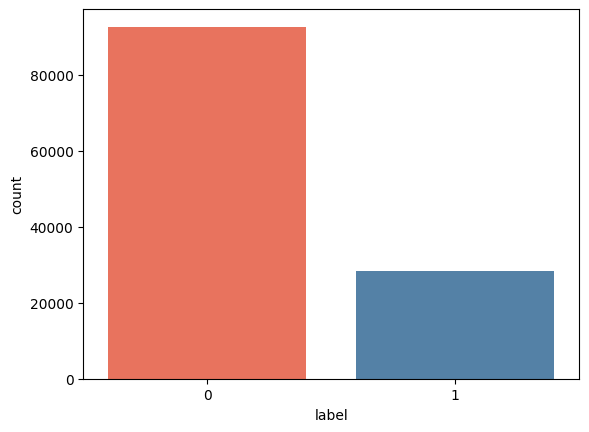

In [113]:
sns.countplot(x=df['label'], data=df,palette=['#FF6347', '#4682B4'])

On va créer une liste de mots suspects qui sont souvent présents dans les URLs de phishing

In [114]:
suspicious_word= ["server", "client", "confirm", "account", "banking", "secure", "ebayisapi", "webscr",
                  "login", "signin", "update", "click", "password", "verify", "lucky", "bonus", "suspend", "paypal",
                  "wordpress", "includes", "admin", "alibaba", "myaccount", "dropbox", "themes", "plugins",
                  "logout", "signout", "submit", "limited", "securewebsession", "redirectme", "recovery", "secured", "refund", "webservis", 
                  "giveaway", "webspace", "webnode", "dispute", "review", "browser", "billing", "temporary",
                  "restore", "verification", "required", "resolution", "000webhostapp", "content", "site", "images", "js", "css", "view"]

In [115]:
# On extraire de nouvelles features 
# Calculer la longueur de l'URL
df['len_url']=[len(url) for url in df['domain']]
# Vérifie si le protocole 'http' ou 'https' est présent
df['presence_protocol'] = [0 if any(url in domain for url in ['http','https'])  else 1 for domain in df['domain']]
# Vérifie si 'www' est présent dans l'URL
df['presence_www']= [0 if "www" in url else 1 for url in  df['domain']]
# Vérifie si '#' est présent dans l'URL
df['presence_#']=[0 if "#" in url else 1 for url in df['domain']]
# Vérifie si '?' est présent dans l'URL
df['presence_?']=[0 if "?" in url else 1 for url in df['domain']]
# Compte le nombre de '.' dans l'URL
df['presence_.']=[url.count(".") for url in df['domain']]
# Vérifie si l'URL contient des mots suspects
df['suspicieux']=[0 if any(url in domain for url in suspicious_word) else 1 for domain in df['domain']]
# Compte le nombre de '/' simple dans l'URL
df['presence_single_slash']=[url.count("/") for url in df['domain']]
# Compte le nombre de '//' dans l'URL
df['presence_double_slash']=[url.count("//") for url in df['domain']]
# Compte le nombre de chiffres dans l'URL
df['compteur_chiffre']=[sum(car.isdigit() for car in url)for url in df['domain']]
# Compte le nombre de caractères spéciaux dans l'URL
caractere_special=[';','+=','_','?','=','&','[',']','-','~']
df['presence_caractere_special']= [sum(char in caractere_special for char in domain) for domain in df['domain']]

In [116]:
df.head()#afficher les premieres lignes 

,domain,label,len_url,presence_protocol,presence_www,presence_#,presence_?,presence_.,suspicieux,presence_single_slash,presence_double_slash,compteur_chiffre,presence_caractere_special
0,http://sprint.com/business/solutions/mobility_...,0,105,0,1,1,0,2,1,6,1,0,5
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0,37,1,1,1,1,3,1,3,0,0,1
2,http://web.de/magazine/digital/sicher-im-netz/...,0,131,0,1,1,1,1,1,6,1,8,10
3,www.wired.com/science/discoveries/news/1999/08...,0,52,1,0,1,1,2,1,6,0,11,0
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1,48,1,1,1,1,3,0,3,0,0,2


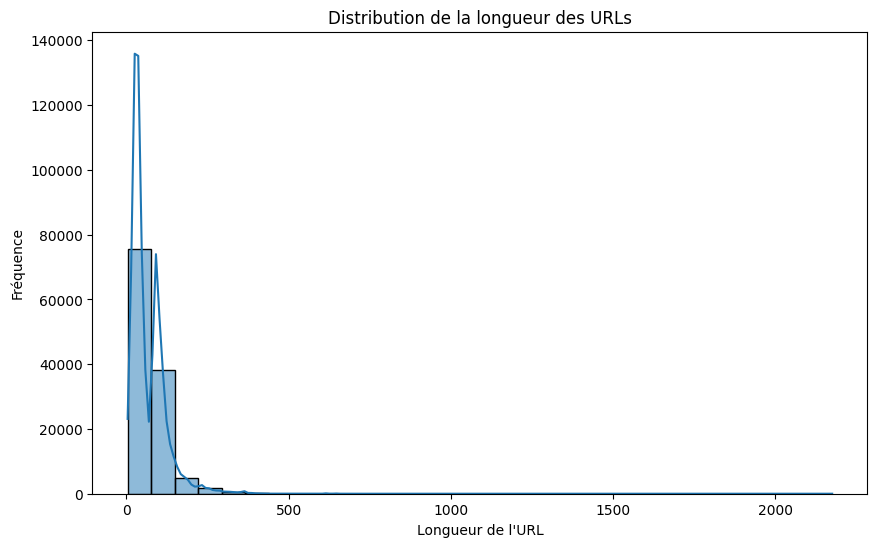

In [117]:
# Distribution de la longueur des URLs
plt.figure(figsize=(10, 6))
sns.histplot(df['len_url'], bins=30, kde=True)
plt.title('Distribution de la longueur des URLs')
plt.xlabel('Longueur de l\'URL')
plt.ylabel('Fréquence')
plt.show()

C:\Users\youssefbaz\AppData\Local\Temp\ipykernel_15612\4017000363.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



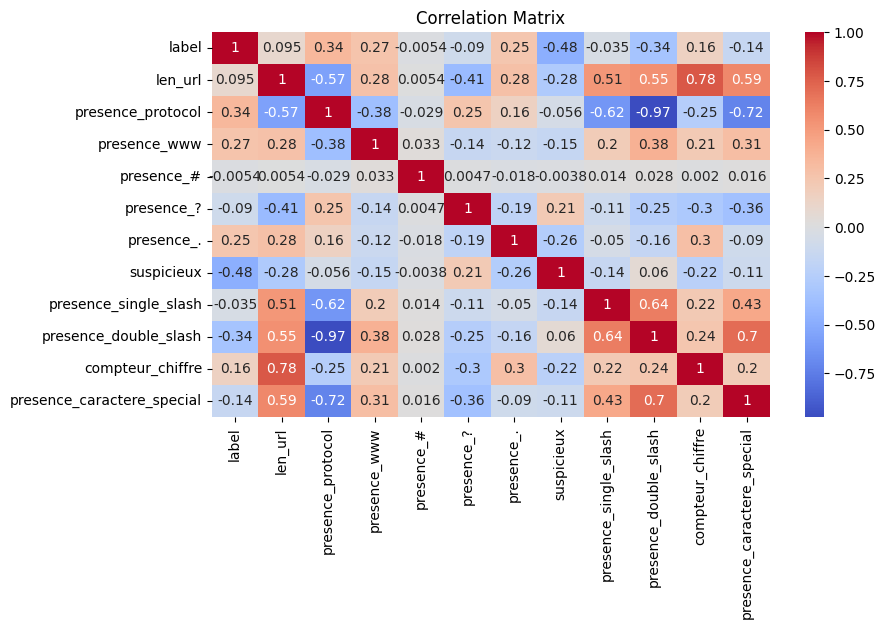

In [122]:
# Correlation matrix
plt.figure(figsize=(9, 5))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

la colonne suspicieux montre une corrélation négative assez notable avec la cible label (-0.48), indiquant que cette caractéristique pourrait être un bon prédicteur de la cible.
De même, presence_double_slash et presence_caractere_special montrent des corrélations négatives de -0.34 et -0.14 respectivement

**On remarque que plusieurs colonnes ont des valeurs relativement grandes, ce qui peut affecter les performances de notre modèle pendant l'entraînement. Pour remédier à cela, nous pouvons normaliser ces valeurs en utilisant une des méthodes de scaling. ici, nous allons utiliser la méthode de standardisation**

In [118]:
#normaliser qlq columns
scaler = StandardScaler()
df[['len_url', 'presence_#','presence_?','presence_.','suspicieux','presence_single_slash','presence_double_slash','compteur_chiffre','presence_caractere_special']] = scaler.fit_transform(df[['len_url', 'presence_#','presence_?','presence_.','suspicieux','presence_single_slash','presence_double_slash','compteur_chiffre','presence_caractere_special']])
#afficher df 
df.head()

,domain,label,len_url,presence_protocol,presence_www,presence_#,presence_?,presence_.,suspicieux,presence_single_slash,presence_double_slash,compteur_chiffre,presence_caractere_special
0,http://sprint.com/business/solutions/mobility_...,0,0.688094,0,1,0.044768,-2.466605,-0.230670,0.492459,1.112137,1.502688,-0.447468,0.379655
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0,-0.531235,1,1,0.044768,0.405416,0.246199,0.492459,-0.134893,-0.641452,-0.447468,-0.456418
2,http://web.de/magazine/digital/sicher-im-netz/...,0,1.154308,0,1,0.044768,0.405416,-0.707540,0.492459,1.112137,1.502688,-0.004534,1.424746
3,www.wired.com/science/discoveries/news/1999/08...,0,-0.262266,1,0,0.044768,0.405416,-0.230670,0.492459,1.112137,-0.641452,0.161566,-0.665436
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1,-0.333991,1,1,0.044768,0.405416,0.246199,-2.030625,-0.134893,-0.641452,-0.447468,-0.247399


**Pour qu'on puisse entraîner notre modèle, nous avons besoin d'équilibrer notre DataFrame  en ayant le même nombre d'URLs légitimes et d'URLs de phishin**g

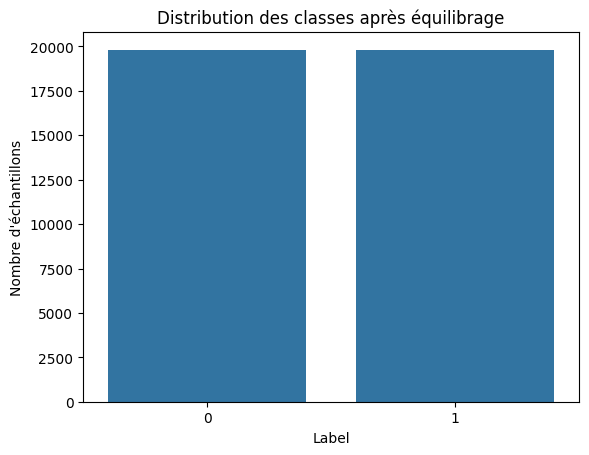

In [119]:

# Définition des caractéristiques et de la target variable 
X = df.drop(columns=['domain', 'label'])
y = df['label']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Combiner les caractéristiques et la cible dans un seul DataFrame
df_combined = pd.concat([X_train, y_train], axis=1)

# Séparer les classes majoritaires et minoritaires
df_majority = df_combined[df_combined.label == 0]
df_minority = df_combined[df_combined.label == 1]

# Downsample la classe majoritaire 
df_majority_downsampled = resample(df_majority, replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=42)  

# Combiner la classe minoritaire  avec le  downsample de la classe majoritaire 
df_balanced = pd.concat([df_minority, df_majority_downsampled])

# Separer features and target
X_resampled = df_balanced.drop('label', axis=1)
y_resampled = df_balanced['label']

# Vérifier la nouvelle distribution des classes
balanced_class_distribution = y_resampled.value_counts()
balanced_class_distribution
# Afficher la nouvelle distribution des classes sous forme de graphique
sns.countplot(x=y_resampled)
plt.title('Distribution des classes après équilibrage')
plt.xlabel('Label')
plt.ylabel('Nombre d\'échantillons')
plt.show()
#on peut voir qu'ils sont bien équilibré 

Nous avons choisi ces algorithmes pour leur complémentarité : RandomForestClassifier pour sa robustesse, et GradientBoostingClassifier pour sa capacité à améliorer la performance en minimisant les erreurs. LogisticRegression est utilisé comme méta-apprenant pour combiner les prédictions des deux modèles de base.

In [120]:
# Définir les apprenants de base
base_learners = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]

# Définir le méta-apprenant
meta_learner = LogisticRegression(random_state=42)

# Creer le stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Train du stacking classifier
stacking_clf.fit(X_resampled, y_resampled)

# Evaluation  du model dans le test set
y_pred = stacking_clf.predict(X_test)
y_pred_prob = stacking_clf.predict_proba(X_test)[:, 1]

# rapport de Classification 
classification_rep = classification_report(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print("ROC AUC Score:", roc_auc)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.95     27804
           1       0.77      0.95      0.85      8493

    accuracy                           0.92     36297
   macro avg       0.88      0.93      0.90     36297
weighted avg       0.93      0.92      0.92     36297

Confusion Matrix:
 [[25356  2448]
 [  410  8083]]
ROC AUC Score: 0.9842957213420556


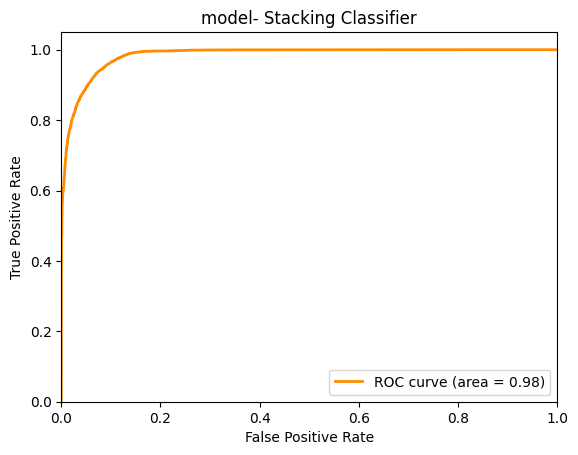

In [130]:
#afficher la courbe roc 
def plot_roc_curve(y_test, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'model- {model_name}')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_test, y_pred_prob, 'Stacking Classifier')

**Recommandations pour la maintenance du modèle**

Détection du drift des données :

pour detecter les drift des data on a plusieurs solutions possible: 
- utiliser des test statistiques comme le test de Kolmogorov-Smirnov pour détecter les différences significatives dans les distributions.
- creer un monitoring: Évaluer régulièrement les performances du modèle sur les nouvelles données.
- utilisation des metrics de performance comme accuracy et le f1-score 
- creer un script de prediction 

**Suggestions pour surveiller les performances du model au fil du temps** 

- Réaliser des tests A/B pour comparer les performances de la version actuelle du modèle avec une version mise à jour 
- avoir un training périodique: Accumuler les nouvelles données sur une période définie (par exemple, chaque mois) et réentraîner complètement le modèle avec l'ensemble des données historiques et les nouvelles données.
- Utiliser des algorithmes qui permettent un apprentissage en continu comme le 'sgdClassifier'